<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/docs-update/examples/tutorial_3_feedforward_snn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Comparison of LIF neuron vs our added Funky neuron (LIF neuron with threshold that randomly changes when a spike is fired). 

This only works if you use our version of snnTorch with `Funky` neuron added, available at [https://github.com/calderast/snntorch/tree/funky]


This notebook is adapted from [snnTorch tutorial 3](https://github.com/jeshraghian/snntorch/blob/master/examples/tutorial_3_feedforward_snn.ipynb).

In [20]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [21]:
#@title Plotting Settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

### `Leaky` Neuron Model vs our added `Funky` Neuron Model in snnTorch

In [22]:
import snntorch as snn
from snntorch._neurons import Leaky, Funky

lif1 = Leaky(beta=0.8)
funky1 = Funky(beta=0.8, funkiness=0.05)

The Leaky neuron model is now stored in `lif1`, and the Funky neuron model stored in `funky1`.
 To use these neurons:

**Inputs**
* `cur_in`: each element of $W\times X[t]$ is sequentially passed as an input
* `mem`: the previous step membrane potential, $U[t-1]$, is also passed as input.

**Outputs**
* `spk_out`: output spike $S[t]$ ('1' if there is a spike; '0' if there is no spike)
* `mem`: membrane potential $U[t]$ of the present step

These all need to be of type `torch.Tensor`. Note that here, we assume the input current has already been weighted before passing into the `snn.Leaky` or `snn.Funky` neurons. This will make more sense when we construct a network-scale model.

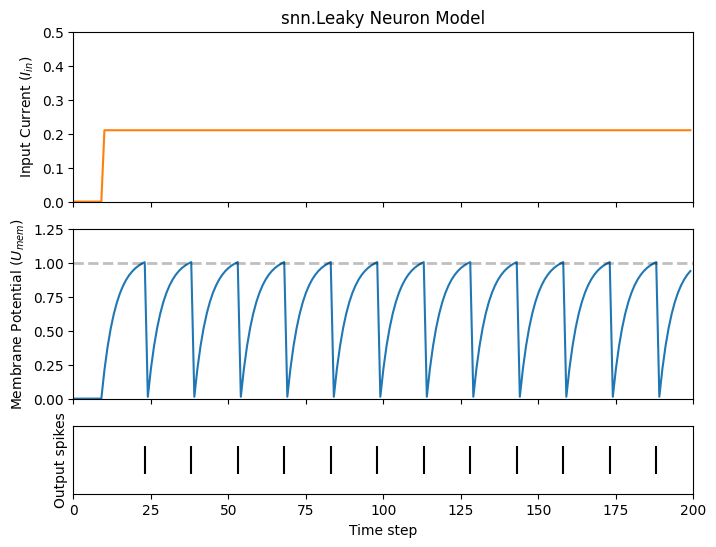

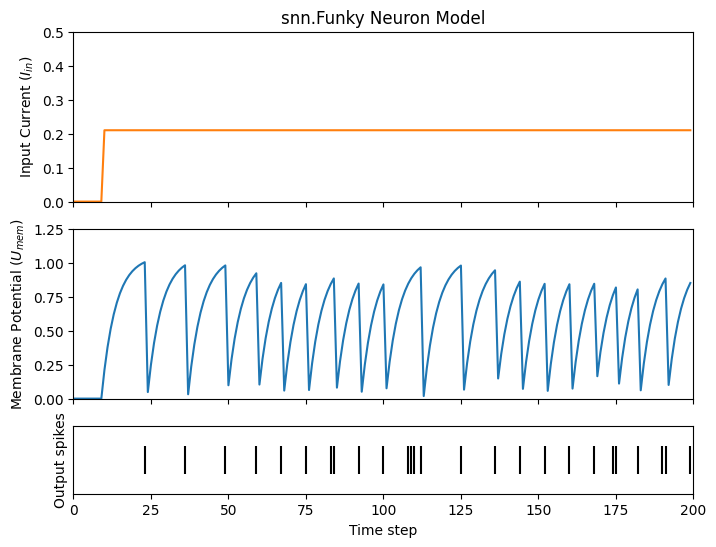

In [23]:
num_steps = 200

# Small step current input
w=0.21
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*w), 0)
# Set up for LIF
mem_lif = torch.zeros(1)
spk_lif = torch.zeros(1)
mem_lif_rec = []
spk_lif_rec = []
# Same but for funky
mem_funky = torch.zeros(1)
spk_funky = torch.zeros(1)
mem_funky_rec = []
spk_funky_rec = []

# Neuron simulation
for step in range(num_steps):
  # LIF
  spk_lif, mem_lif = lif1(cur_in[step], mem_lif)
  mem_lif_rec.append(mem_lif)
  spk_lif_rec.append(spk_lif)
  # Funky
  spk_funky, mem_funky = funky1(cur_in[step], mem_funky)
  mem_funky_rec.append(mem_funky)
  spk_funky_rec.append(spk_funky)

# Convert lists to tensors
mem_lif_rec = torch.stack(mem_lif_rec)
spk_lif_rec = torch.stack(spk_lif_rec)
mem_funky_rec = torch.stack(mem_funky_rec)
spk_funky_rec = torch.stack(spk_funky_rec)

plot_cur_mem_spk(cur_in, mem_lif_rec, spk_lif_rec, thr_line=1, ylim_max1=0.5,
                 title="snn.Leaky Neuron Model")
plot_cur_mem_spk(cur_in, mem_funky_rec, spk_funky_rec, ylim_max1=0.5,
                 title="snn.Funky Neuron Model")

# 3. A Feedforward Spiking Neural Network

So far, we have only considered how a single neuron responds to input stimulus. snnTorch makes it straightforward to scale this up to a deep neural network. In this section, we will create a 3-layer fully-connected neural network of dimensions 784-1000-10. Compared to our simulations so far, each neuron will now integrate over many more incoming input spikes. 


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_8_fcn.png?raw=true' width="600">
</center>

PyTorch is used to form the connections between neurons, and snnTorch to create the neurons. First, initialize all layers.

In [7]:
# layer parameters
num_inputs = 784
num_hidden = 1000
num_outputs = 10
beta = 0.99

# initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
lif1 = Leaky(beta=beta)
fc2 = nn.Linear(num_hidden, num_outputs)
lif2 = Leaky(beta=beta)

Next, initialize the hidden variables and outputs of each spiking neuron. 
As networks increase in size, this becomes more tedious. The static method `init_leaky()` can be used to take care of this. All neurons in snnTorch have their own initialization methods that follow this same syntax, e.g., `init_lapicque()`. The shape of the hidden states are automatically initialized based on the input data dimensions during the first forward pass. 

In [8]:
# Initialize hidden states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# record outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

Create an input spike train to pass to the network. There are 200 time steps to simulate across 784 input neurons, i.e., the input originally has dimensions of $200 \times 784$. However, neural nets typically process data in minibatches. snnTorch uses time-first dimensionality: 

[$time \times batch\_size \times feature\_dimensions$]

So 'unsqueeze' the input along `dim=1` to indicate 'one batch' of data. The dimensions of this input tensor must be 200 $\times$ 1 $\times$ 784:

In [9]:
spk_in = spikegen.rate_conv(torch.rand((200, 784))).unsqueeze(1)
print(f"Dimensions of spk_in: {spk_in.size()}")

Dimensions of spk_in: torch.Size([200, 1, 784])


Now it's finally time to run a full simulation. 
An intuitive way to think about how PyTorch and snnTorch work together is that PyTorch routes the neurons together, and snnTorch loads the results into spiking neuron models. In terms of coding up a network, these spiking neurons can be treated like time-varying activation functions.

Here is a sequential account of what's going on:

*  The $i^{th}$ input from `spk_in` to the $j^{th}$ neuron is weighted by the parameters initialized in `nn.Linear`: $X_{i} \times W_{ij}$
* This generates the input current term from Equation $(10)$, contributing to $U[t+1]$ of the spiking neuron
* If $U[t+1] > U_{\rm thr}$, then a spike is triggered from this neuron
* This spike is weighted by the second layer weight, and the above process is repeated for all inputs, weights, and neurons.
* If there is no spike, then nothing is passed to the post-synaptic neuron.

The only difference from our simulations thus far is that we are now scaling the input current with a weight generated by `nn.Linear`, rather than manually setting $W$ ourselves.

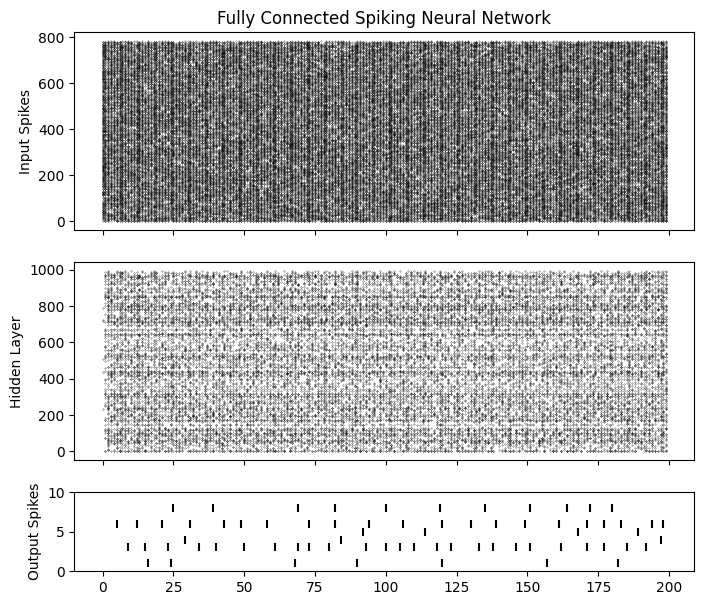

In [10]:
# network simulation
for step in range(num_steps):
    cur1 = fc1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem[t+1] <--post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network")

Dimensions of spk_in: torch.Size([200, 1, 784])


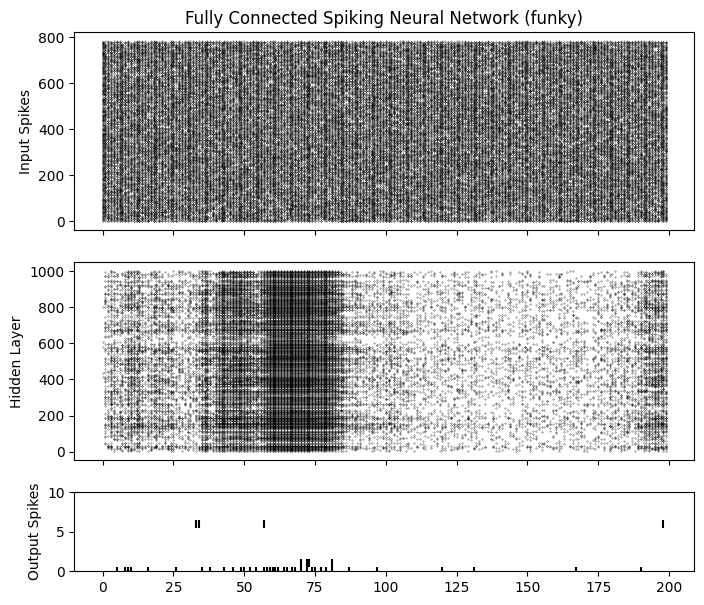

In [29]:
# Now do the same with funky!

# layer parameters
num_inputs = 784
num_hidden = 1000
num_outputs = 10
beta = 0.99

# initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
funky1 = Funky(beta=beta, funkiness=0.2)
fc2 = nn.Linear(num_hidden, num_outputs)
funky2 = Funky(beta=beta, funkiness=0.2)

# Initialize hidden states
mem1 = funky1.init_funky()
mem2 = funky2.init_funky()

# record outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

spk_in = spikegen.rate_conv(torch.rand((200, 784))).unsqueeze(1)
print(f"Dimensions of spk_in: {spk_in.size()}")

# network simulation
for step in range(num_steps):
    cur1 = fc1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    spk1, mem1 = funky1(cur1, mem1) # mem[t+1] <--post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = funky2(cur2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network (funky)")

> If you run into errors, then try re-initializing your networks and parameters.


At this stage, the spikes don't have any real meaning. The inputs and weights are all randomly initialized, and no training has taken place. But the spikes  should appear to be propagating from the first layer through to the output. If you are not seeing any spikes, then you might have been unlucky in the weight initialization lottery - you might want to try re-running the last four code-blocks. 

`spikeplot.spike_count` can create a spike counter of the output layer. The following animation will take some time to generate. <br>

> Note: if you are running the notebook locally on your desktop, please uncomment the line below and modify the path to your ffmpeg.exe



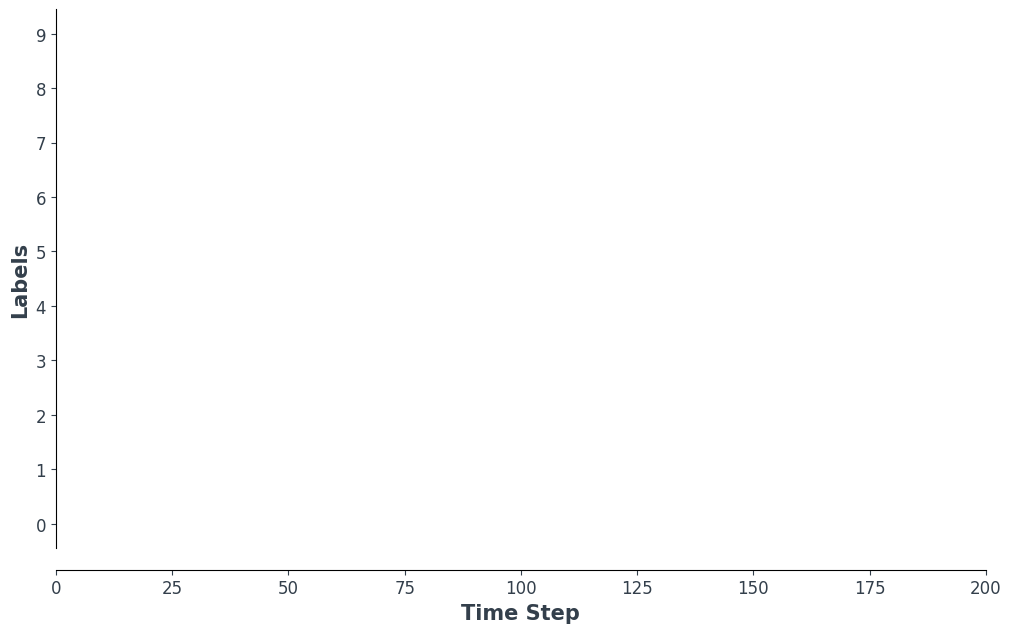

In [30]:
from IPython.display import HTML

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
spk2_rec = spk2_rec.squeeze(1).detach().cpu()

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk2_rec, fig, ax, labels=labels, animate=True)
HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

`spikeplot.traces` lets you visualize the membrane potential traces. We will plot 9 out of 10 output neurons. 
Compare it to the animation and raster plot above to see if you can match the traces to the neuron. 

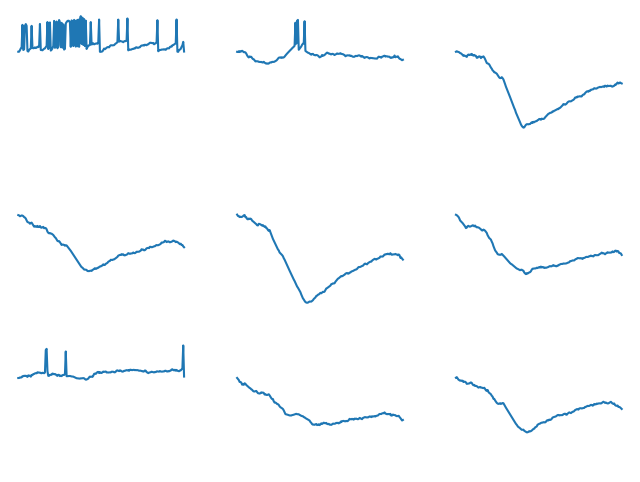

In [31]:
# plot membrane potential traces
splt.traces(mem2_rec.squeeze(1), spk=spk2_rec.squeeze(1))
fig = plt.gcf() 
fig.set_size_inches(8, 6)

Some neurons are firing while others are completely dead. None of these spikes have any real meaning until the weights have been trained.

## Training the network

Adapted from Tutorial 5

In [3]:
# Define functions to compute accuracy
# (pass data into the network, sum the spikes over time and compare the neuron with the highest number of spikes with the target)

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [4]:
from snntorch._neurons import Funky
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

num_inputs = 28*28
num_hidden = 1000
num_outputs = 10
num_steps = 25
beta = 0.95

## Define funky network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers using funky neuron
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.funky1 = Funky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.funky2 = Funky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.funky1.init_funky()
        mem2 = self.funky2.init_funky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.funky1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.funky2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

#torch.manual_seed(37)
net = Net()

batch_size = 128
data_path='/tmp/data/mnist'
dtype = torch.float
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])
mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
data, targets = next(iter(train_loader))

# Training loop
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1



Epoch 0, Iteration 0
Train Set Loss: 60.17
Test Set Loss: 53.23
Train set accuracy for a single minibatch: 50.78%
Test set accuracy for a single minibatch: 32.03%




KeyboardInterrupt: 

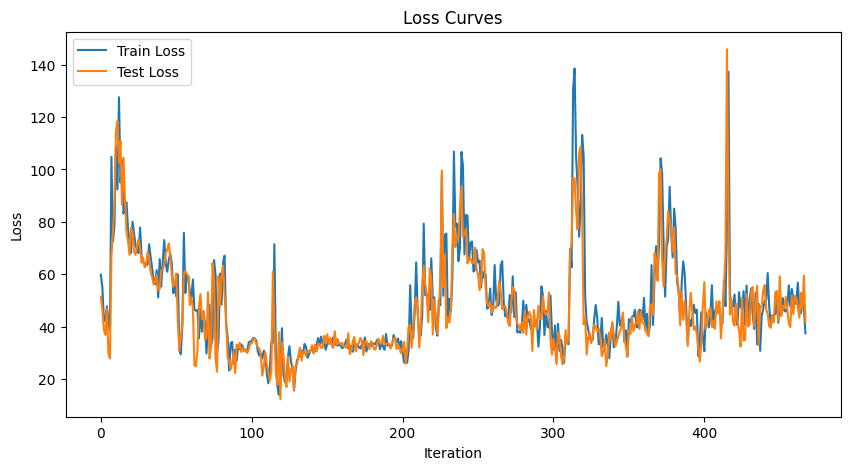

In [28]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()


In [17]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    
    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 8643/10000
Test Set Accuracy: 86.43%


# Funkiness vs accuracy
How robust is our SNN?

In [12]:
from snntorch._neurons import Funky
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

funkiness_list = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

num_inputs = 28*28
num_hidden = 1000
num_outputs = 10
num_steps = 25
beta = 0.95

overall_accuracies = []
for funkiness in funkiness_list:
    
    accuracies = []
    for repeat in range(10):

        ## Define funky network
        class Net(nn.Module):
            def __init__(self):
                super().__init__()

                # Initialize layers using funky neuron
                self.fc1 = nn.Linear(num_inputs, num_hidden)
                self.funky1 = Funky(beta=beta, funkiness=funkiness)
                self.fc2 = nn.Linear(num_hidden, num_outputs)
                self.funky2 = Funky(beta=beta, funkiness=funkiness)

            def forward(self, x):
                mem1 = self.funky1.init_funky()
                mem2 = self.funky2.init_funky()
                spk2_rec = []
                mem2_rec = []

                for step in range(num_steps):
                    cur1 = self.fc1(x)
                    spk1, mem1 = self.funky1(cur1, mem1)
                    cur2 = self.fc2(spk1)
                    spk2, mem2 = self.funky2(cur2, mem2)
                    spk2_rec.append(spk2)
                    mem2_rec.append(mem2)
                return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

        net = Net()

        batch_size = 128
        data_path='/tmp/data/mnist'
        dtype = torch.float
        transform = transforms.Compose([
                transforms.Resize((28, 28)),
                transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Normalize((0,), (1,))])
        mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
        mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
        train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
        test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

        loss = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
        data, targets = next(iter(train_loader))

        # Training
        num_epochs = 1
        for epoch in range(num_epochs):
            iter_counter = 0
            train_batch = iter(train_loader)

            for data, targets in train_batch:
                net.train()
                spk_rec, mem_rec = net(data.view(batch_size, -1))

                loss_val = torch.zeros((1), dtype=dtype)
                for step in range(num_steps):
                    loss_val += loss(mem_rec[step], targets)

                optimizer.zero_grad()
                loss_val.backward()
                optimizer.step()

        # Accuracy
        total = 0
        correct = 0
        test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)
        with torch.no_grad():
            net.eval()
            for data, targets in test_loader:
                test_spk, _ = net(data.view(data.size(0), -1))
                _, predicted = test_spk.sum(dim=0).max(1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        accuracy = 100 * correct / total
        print(f"Funkiness: {funkiness}")
        print(f"Total correctly classified test set images: {correct}/{total}")
        print(f"Test Set Accuracy: {accuracy:.2f}%")

        accuracies.append(accuracy)
    print(accuracies)
    overall_accuracies.append(accuracies)



Funkiness: 0
Total correctly classified test set images: 9444/10000
Test Set Accuracy: 94.44%
Funkiness: 0
Total correctly classified test set images: 9275/10000
Test Set Accuracy: 92.75%
Funkiness: 0
Total correctly classified test set images: 9385/10000
Test Set Accuracy: 93.85%
Funkiness: 0
Total correctly classified test set images: 9467/10000
Test Set Accuracy: 94.67%
Funkiness: 0
Total correctly classified test set images: 9456/10000
Test Set Accuracy: 94.56%
Funkiness: 0
Total correctly classified test set images: 9278/10000
Test Set Accuracy: 92.78%
Funkiness: 0
Total correctly classified test set images: 9323/10000
Test Set Accuracy: 93.23%
Funkiness: 0
Total correctly classified test set images: 9438/10000
Test Set Accuracy: 94.38%
Funkiness: 0
Total correctly classified test set images: 9527/10000
Test Set Accuracy: 95.27%
Funkiness: 0
Total correctly classified test set images: 9284/10000
Test Set Accuracy: 92.84%
[94.44, 92.75, 93.85, 94.67, 94.56, 92.78, 93.23, 94.38, 95.

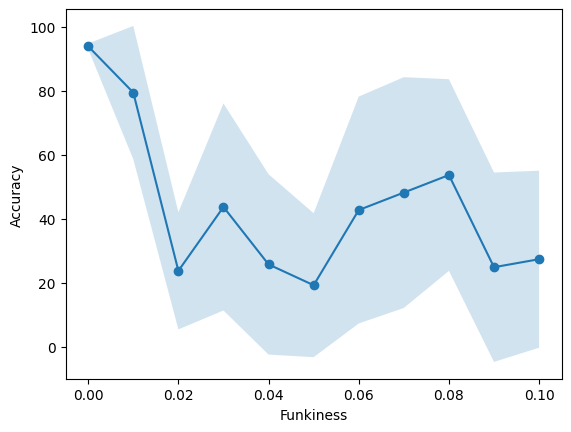

In [ ]:
# Copied from above in case I want to mess with plotting but lose this variable
overall_accuracies = [[94.44, 92.75, 93.85, 94.67, 94.56, 92.78, 93.23, 94.38, 95.27, 92.84],
[93.04, 94.98, 92.19, 78.62, 93.09, 82.55, 90.51, 64.42, 81.87, 22.84],
[21.5, 9.8, 35.92, 20.97, 18.5, 73.2, 12.09, 9.8, 9.8, 25.18],
[91.8, 71.47, 9.97, 88.49, 67.48, 9.8, 9.8, 29.05, 9.8, 48.77],
[75.04, 9.81, 9.8, 25.88, 10.09, 87.02, 9.8, 9.8, 9.8, 9.8],
[19.04, 10.68, 9.8, 10.34, 9.8, 9.81, 11.09, 10.01, 86.14, 15.07],
[10.54, 74.39, 9.84, 19.04, 89.26, 26.2, 9.8, 86.11, 9.8, 91.87],
[15.84, 10.1, 19.34, 62.61, 90.75, 9.82, 9.8, 83.38, 88.38, 91.45],
[80.16, 9.8, 84.91, 85.96, 44.31, 88.58, 12.55, 55.03, 17.35, 57.6],
[9.8, 9.8, 11.26, 9.8, 9.99, 84.82, 83.22, 9.8, 9.75, 9.8],
[87.78, 9.8, 27.55, 9.8, 73.8, 9.8, 9.8, 9.8, 9.91, 25.08]]

means = [np.mean(acc) for acc in overall_accuracies]
stds = [np.std(acc) for acc in overall_accuracies]

# Plot mean as a line with shaded zone for std
plt.plot(funkiness_list, means, marker='o')
plt.fill_between(funkiness_list,[m-s for m, s in zip(means, stds)], [m+s for m, s in zip(means, stds)], alpha=0.2)
plt.xlabel('Funkiness')
plt.ylabel('Accuracy')
plt.show()